
# 🧠 Liver Tumor / Liver Segmentation with U-Net (LiTS17, GPU-Accelerated)

**Author:** Sohel Ahmed  

**Goal:** End-to-end medical imaging workflow using the **LiTS17** dataset: load NIfTI volumes, prepare training slices, train a **2D U-Net** for liver segmentation, and visualize predictions.

**Highlights**
- Real hospital-grade formats (**NIfTI**).
- Clean training pipeline with **TensorFlow/Keras**.
- Proper **Dice loss** for class imbalance.
- Clear visualizations and evaluation (Dice/IoU).

> Tip: This notebook is sized for a portfolio demo. Start with a few volumes and ~200 slices; scale up later.


## 0. Environment Check

In [1]:

import sys, os, platform, numpy as np, matplotlib.pyplot as plt
print("Python :", sys.version)
print("OS     :", platform.platform())

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("TensorFlow import issue:", e)

try:
    import nibabel as nib
    print("nibabel:", nib.__version__)
except Exception as e:
    print("nibabel import issue:", e)


Python : 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
OS     : Windows-10-10.0.26100-SP0
TensorFlow: 2.16.2
GPU devices: []
nibabel: 5.2.1



## 1. Paths & Dataset

- Dataset: **LiTS17** (Liver Tumor Segmentation Challenge).
- Files are NIfTI (`.nii`). Each `volume-XX.nii` has a matching `segmentation-XX.nii`.
- Place volumes in a folder like: `C:/Users/sohel/Downloads/Ai_health/LITS17` where each item may be a **subfolder** containing the `.nii` file.

Edit the `data_dir` and the specific IDs you want to use below.


In [2]:

from pathlib import Path
import os

# 🔧 EDIT THIS PATH
data_dir = Path(r"C:\Users\sohel\Downloads\Ai_health\LiTS17")

# Choose a case index to start (ensure both exist)
case_id = 84  # example case

vol_path = data_dir / f"volume-{case_id}.nii" / f"volume-{case_id}.nii"
seg_path = data_dir / f"segmentation-{case_id}.nii" / f"segmentation-{case_id}.nii"

print("Volume path     :", vol_path)
print("Segmentation path:", seg_path)
print("Exists? vol:", vol_path.exists(), "seg:", seg_path.exists())


Volume path     : C:\Users\sohel\Downloads\Ai_health\LiTS17\volume-84.nii\volume-84.nii
Segmentation path: C:\Users\sohel\Downloads\Ai_health\LiTS17\segmentation-84.nii\segmentation-84.nii
Exists? vol: True seg: True


## 2. Load & Inspect One Case

Image shape: (512, 512, 733) dtype: float32
Mask  shape: (512, 512, 733) unique labels: [0 1]


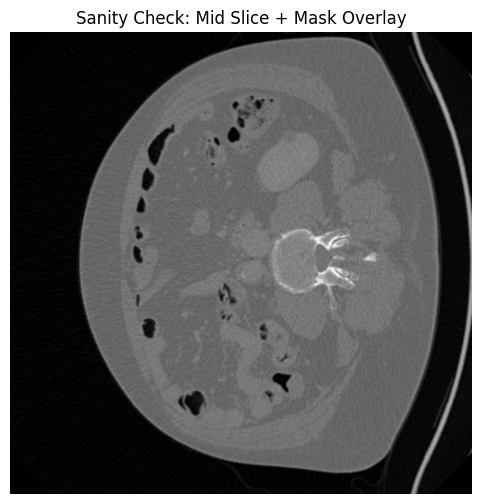

In [3]:

import nibabel as nib
import numpy as np

img = nib.load(str(vol_path))
mask = nib.load(str(seg_path))

img_data = img.get_fdata().astype(np.float32)
mask_data = (mask.get_fdata() > 0).astype(np.uint8)

print("Image shape:", img_data.shape, "dtype:", img_data.dtype)
print("Mask  shape:", mask_data.shape, "unique labels:", np.unique(mask_data))

mid = img_data.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(img_data[:,:,mid], cmap="gray")
plt.imshow(np.ma.masked_where(mask_data[:,:,mid]==0, mask_data[:,:,mid]), alpha=0.4, cmap="jet")
plt.title("Sanity Check: Mid Slice + Mask Overlay")
plt.axis("off"); plt.show()



## 3. Prepare Training Slices (2D)

We convert the 3D volume into a set of 2D axial slices. For a light demo, we sample ~200 random slices.


Train: (180, 512, 512, 1) (180, 512, 512, 1)
Val  : (20, 512, 512, 1) (20, 512, 512, 1)


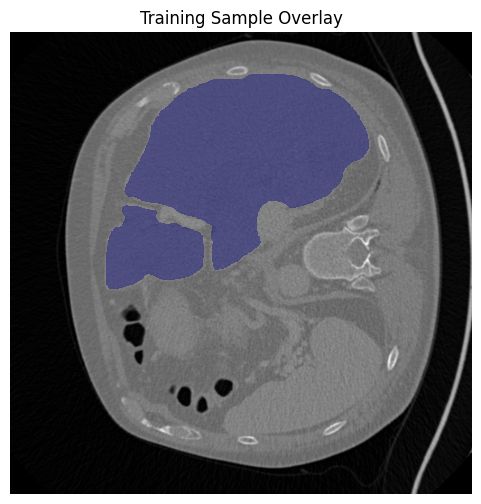

In [4]:

from sklearn.model_selection import train_test_split

# Normalize intensities (robust windowing optional)
img_norm = img_data / np.max(img_data)

# Random slice sampling
n_total = img_data.shape[2]
rng = np.random.default_rng(42)
slice_ids = rng.choice(np.arange(n_total), size=min(200, n_total), replace=False)

X = np.transpose(img_norm[:,:,slice_ids], (2,0,1))  # (N, H, W)
Y = np.transpose(mask_data[:,:,slice_ids], (2,0,1)) # (N, H, W)

# Add channel dimension
X = X[..., None].astype(np.float32)   # (N, H, W, 1)
Y = Y[..., None].astype(np.uint8)     # (N, H, W, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Train:", X_train.shape, Y_train.shape)
print("Val  :", X_val.shape, Y_val.shape)

# Quick visualization of one training example
i = 0
plt.figure(figsize=(6,6))
plt.imshow(X_train[i,:,:,0], cmap="gray")
plt.imshow(np.ma.masked_where(Y_train[i,:,:,0]==0, Y_train[i,:,:,0]), alpha=0.4, cmap="jet")
plt.title("Training Sample Overlay"); plt.axis("off"); plt.show()


## 4. Loss & Metrics (Dice)

In [5]:

import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


## 5. U-Net Model

In [6]:

from tensorflow.keras import layers, models

def build_unet(input_shape=(512, 512, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D(2)(c3); u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D(2)(c4); u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs, name="U-Net-2D")

tf.keras.backend.clear_session()
model = build_unet(input_shape=(X_train.shape[1], X_train.shape[2], 1))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()


Model: "U-Net-2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 512, 512,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 512,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 512, 512,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train

In [7]:

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=2,
    verbose=1
)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9671 - dice_coef: 0.1742 - loss: 1.0380 - val_accuracy: 0.9795 - val_dice_coef: 0.1112 - val_loss: 0.9410
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9791 - dice_coef: 0.2148 - loss: 0.8396 - val_accuracy: 0.9791 - val_dice_coef: 0.2204 - val_loss: 0.8459
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9811 - dice_coef: 0.2793 - loss: 0.7748 - val_accuracy: 0.9792 - val_dice_coef: 0.2392 - val_loss: 0.8350
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9852 - dice_coef: 0.3701 - loss: 0.6809 - val_accuracy: 0.9896 - val_dice_coef: 0.2793 - val_loss: 0.7543
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9851 - dice_coef: 0.3802 - loss: 0.6747 - val_accuracy: 0.9886 - val_dice_coef: 0.2270 - val_loss: 0.8197


## 7. Evaluate & Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


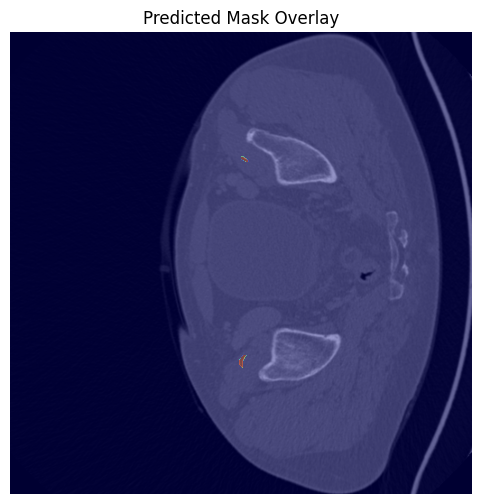

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Validation Dice (mean): 0.4593938857597338


In [8]:

# Predict one validation sample
idx = 0
pred = model.predict(X_val[idx:idx+1])[0,:,:,0]

plt.figure(figsize=(6,6))
plt.imshow(X_val[idx,:,:,0], cmap="gray")
plt.imshow(pred>0.5, alpha=0.4, cmap="jet")
plt.title("Predicted Mask Overlay"); plt.axis("off"); plt.show()

# Compute Dice on validation
def dice_numpy(y_true, y_pred, eps=1.0):
    y_true_f = y_true.flatten().astype(np.float32)
    y_pred_f = y_pred.flatten().astype(np.float32)
    inter = (y_true_f*y_pred_f).sum()
    return (2*inter + eps) / (y_true_f.sum() + y_pred_f.sum() + eps)

val_pred = (model.predict(X_val)[:,:,:,:] > 0.5).astype(np.uint8)
dice_scores = [dice_numpy(Y_val[i,:,:,0], val_pred[i,:,:,0]) for i in range(len(Y_val))]
print("Validation Dice (mean):", float(np.mean(dice_scores)))



## 8. Notes & Next Steps

- **3D U-Net / nnU-Net**: For higher accuracy, consider 3D models or MONAI.
- **Augmentation**: Add rotations, flips, elastic deformations to improve generalization.
- **Post-processing**: Largest connected component, morphological opening to clean masks.
- **Clinical linkage**: Extract radiomics features (e.g., PyRadiomics) for survival modeling (Cox/DeepSurv).
- **Reproducibility**: Seed control, experiment tracking (MLflow), and environment files.

> This notebook demonstrates a clinically relevant end-to-end imaging AI pipeline aligned with oncology theranostics workflows.


In [9]:
def window_ct(x, wl=-100, wh=400):
    x = np.clip(x, wl, wh)
    return (x - wl) / (wh - wl)

img_win = window_ct(img_data.astype(np.float32))


In [10]:
import zipfile, os
from pathlib import Path

data_dir = Path(r"C:\Users\sohel\Downloads\Ai_health\LITS17")
out_dir = data_dir / "unzipped"
out_dir.mkdir(exist_ok=True)

for f in data_dir.glob("*.nii.zip"):
    case_name = f.stem  # e.g. "volume-84.nii"
    target = out_dir / case_name
    if target.exists():
        continue
    try:
        with zipfile.ZipFile(f, 'r') as zf:
            zf.extractall(target)
        print(f"✅ Extracted {case_name}")
    except Exception as e:
        print(f"⚠️ Skipped {f.name}: {e}")

print("Done unzipping to:", out_dir)


Done unzipping to: C:\Users\sohel\Downloads\Ai_health\LITS17\unzipped


In [11]:
data_dir = Path(r"C:\Users\sohel\Downloads\Ai_health\LITS17\unzipped")


In [12]:
case_ids = [84, 85, 86]  # pick any 2–3 cases you extracted

def load_case(case_id):
    vol_path = data_dir / f"volume-{case_id}.nii" / f"volume-{case_id}.nii"
    seg_path = data_dir / f"segmentation-{case_id}.nii" / f"segmentation-{case_id}.nii"
    if not vol_path.exists() or not seg_path.exists():
        print(f"⚠️ Skipping {case_id} — files missing.")
        return None
    vol = nib.load(str(vol_path)).get_fdata()
    seg = nib.load(str(seg_path)).get_fdata() > 0
    return window_ct(vol.astype(np.float32)), seg.astype(np.uint8)

data = [load_case(cid) for cid in case_ids]
data = [d for d in data if d is not None]
vols, segs = zip(*data)


In [13]:
print(f"Loaded {len(vols)} valid cases.")
for i, (v, s) in enumerate(zip(vols, segs)):
    print(f"Case {i}: volume shape {v.shape}, segmentation shape {s.shape}, mask ratio {(s>0).mean():.4f}")


Loaded 3 valid cases.
Case 0: volume shape (512, 512, 733), segmentation shape (512, 512, 733), mask ratio 0.0283
Case 1: volume shape (512, 512, 630), segmentation shape (512, 512, 630), mask ratio 0.0429
Case 2: volume shape (512, 512, 647), segmentation shape (512, 512, 647), mask ratio 0.0316


In [14]:
import numpy as np
X_all = np.concatenate([v.transpose(2,0,1)[...,None] for v in vols])  # (N, 512, 512, 1)
Y_all = np.concatenate([s.transpose(2,0,1)[...,None] for s in segs])
print("Combined dataset:", X_all.shape, Y_all.shape)


Combined dataset: (2010, 512, 512, 1) (2010, 512, 512, 1)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)


In [11]:
tf.keras.backend.clear_session()
model = build_unet(input_shape=(512,512,1))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', dice_coef])

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=2
)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9766 - dice_coef: 0.1349 - loss: 0.9662 - val_accuracy: 0.9879 - val_dice_coef: 0.1571 - val_loss: 0.8811
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9784 - dice_coef: 0.2559 - loss: 0.7977 - val_accuracy: 0.9891 - val_dice_coef: 0.2388 - val_loss: 0.8097
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9830 - dice_coef: 0.3549 - loss: 0.7034 - val_accuracy: 0.9800 - val_dice_coef: 0.2240 - val_loss: 0.8421
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9837 - dice_coef: 0.3652 - loss: 0.6877 - val_accuracy: 0.9882 - val_dice_coef: 0.2720 - val_loss: 0.7659
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9881 - dice_coef: 0.3435 - loss: 0.7171 - val_accuracy: 0.9899 - val_dice_coef: 0.2831 - val_loss: 0.7460


In [14]:
val_pred = (model.predict(X_val) > 0.5).astype(np.uint8)
dice_scores = [dice_numpy(Y_val[i,:,:,0], val_pred[i,:,:,0]) for i in range(len(Y_val))]
print("Validation Dice (mean):", np.mean(dice_scores))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Validation Dice (mean): 0.3004095876686634


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_unet_lits17.h5", monitor='val_dice_coef', save_best_only=True, mode='max')
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=2,
    callbacks=callbacks
)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9885 - dice_coef: 0.4296 - loss: 0.6088

90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9895 - dice_coef: 0.3942 - loss: 0.6443 - val_accuracy: 0.9908 - val_dice_coef: 0.3718 - val_loss: 0.6905
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9861 - dice_coef: 0.4114 - loss: 0.7007 - val_accuracy: 0.9901 - val_dice_coef: 0.2981 - val_loss: 0.7342
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9893 - dice_coef: 0.3980 - loss: 0.6459 - val_accuracy: 0.9915 - val_dice_coef: 0.2931 - val_loss: 0.7319
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9876 - dice_coef: 0.4190 - loss: 0.6689 - val_accuracy: 0.9909 - val_dice_coef: 0.2942 - val_loss: 0.7374
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9899 - dice_coef: 0.4025 - loss: 0.6502 - val_accuracy: 0.9844 - val_dice_coef: 0.3037 - val_loss: 0.8374
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9839 - dice_coef: 0.3514 - loss: 1.0908

90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9763 - dice_coef: 0.2950 - loss: 1.0656 - val_accuracy: 0.9795 - val_dice_coef: 0.3906 - val_loss: 0.7948
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9788 - dice_coef: 0.4065 - loss: 0.8377

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9763 - dice_coef: 0.3878 - loss: 0.8712 - val_accuracy: 0.9795 - val_dice_coef: 0.4378 - val_loss: 0.8034
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9763 - dice_coef: 0.3829 - loss: 0.9120 - val_accuracy: 0.9795 - val_dice_coef: 0.2454 - val_loss: 0.8945
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9763 - dice_coef: 0.3265 - loss: 0.9200 - val_accuracy: 0.9795 - val_dice_coef: 0.2233 - val_loss: 0.9190
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9763 - dice_coef: 0.3036 - loss: 0.9005

90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.9763 - dice_coef: 0.3108 - loss: 0.9390 - val_accuracy: 0.9795 - val_dice_coef: 0.4985 - val_loss: 0.8276
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9763 - dice_coef: 0.4236 - loss: 0.7905 - val_accuracy: 0.9795 - val_dice_coef: 0.3554 - val_loss: 0.7875
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9784 - dice_coef: 0.2565 - loss: 0.9044 - val_accuracy: 0.9922 - val_dice_coef: 0.2940 - val_loss: 0.7314
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9904 - dice_coef: 0.3905 - loss: 0.6435 - val_accuracy: 0.9911 - val_dice_coef: 0.3122 - val_loss: 0.7183
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9901 - dice_coef: 0.4072 - loss: 0.6284 - val_accuracy: 0.9925 - val_dice_coef: 0.3270 - val_loss: 0.7011
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9880 - dice_coef: 0.3866 - loss: 0.6874 - val_accuracy: 0.9920 - val_dice_

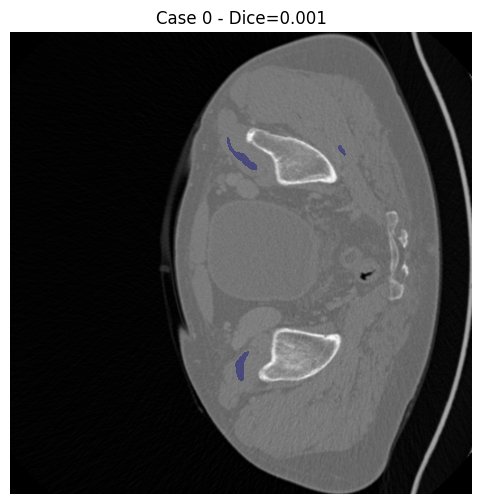

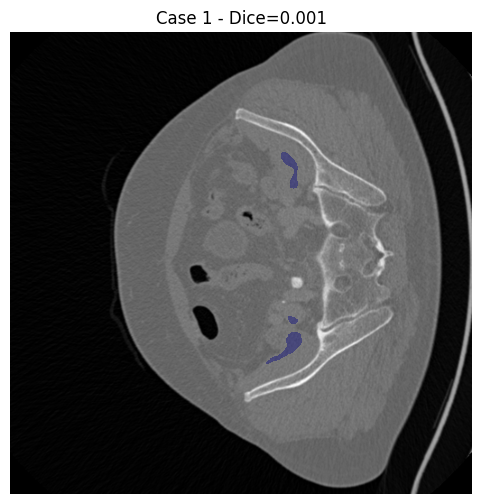

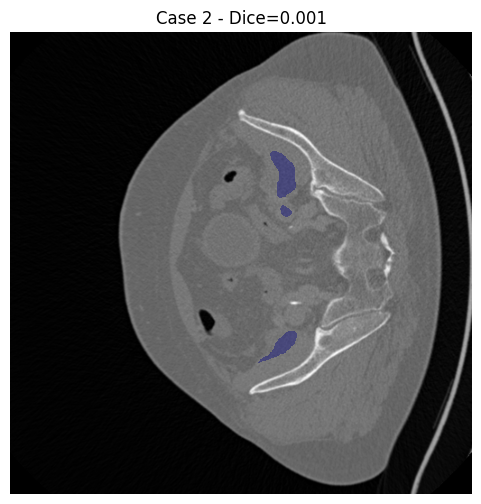

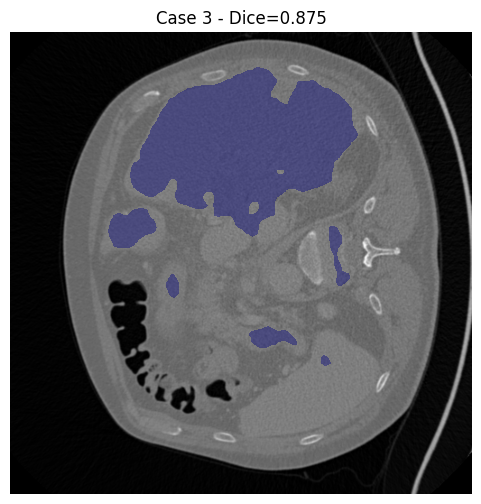

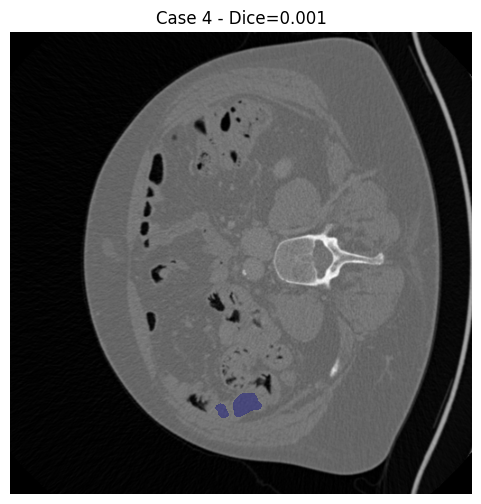

In [16]:
for i in range(5):
    plt.figure(figsize=(6,6))
    plt.imshow(X_val[i,:,:,0], cmap="gray")
    plt.imshow(np.ma.masked_where(val_pred[i,:,:,0]==0, val_pred[i,:,:,0]), alpha=0.4, cmap="jet")
    plt.title(f"Case {i} - Dice={dice_scores[i]:.3f}")
    plt.axis("off")
    plt.show()


In [17]:
print("Dice mean:", np.mean(dice_scores), "±", np.std(dice_scores))


Dice mean: 0.3004095876686634 ± 0.41180826941420584


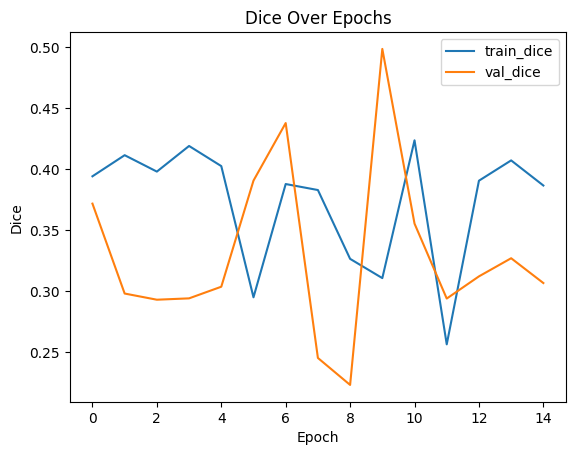

In [18]:
plt.plot(history.history['dice_coef'], label='train_dice')
plt.plot(history.history['val_dice_coef'], label='val_dice')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Dice Over Epochs'); plt.show()


In [22]:
import nibabel as nib
import numpy as np
from pathlib import Path

# Base data folder (adjust if needed)
data_dir = Path(r"C:\Users\sohel\Downloads\Ai_health\LiTS17")

# Optional: CT windowing for visualization
def window_ct(x, wl=-100, wh=400):
    x = np.clip(x, wl, wh)
    return (x - wl) / (wh - wl)

def load_case(case_id):
    """Load LiTS17 case and segmentation."""
    vol_path = data_dir / f"volume-{case_id}.nii" / f"volume-{case_id}.nii"
    seg_path = data_dir / f"segmentation-{case_id}.nii" / f"segmentation-{case_id}.nii"

    if not vol_path.exists() or not seg_path.exists():
        print(f"⚠️ Skipping {case_id} — files missing.")
        return None, None

    vol = nib.load(str(vol_path)).get_fdata()
    seg = nib.load(str(seg_path)).get_fdata() > 0

    vol = window_ct(vol.astype(np.float32))
    seg = seg.astype(np.uint8)

    return vol, seg


In [23]:
new_vol, new_seg = load_case(87)

if new_vol is not None:
    preds = []
    for z in range(new_vol.shape[2]):
        sl = new_vol[:, :, z][None, :, :, None]  # shape (1, 512, 512, 1)
        pred = model.predict(sl, verbose=0)[0, :, :, 0]
        preds.append(pred)

    preds = np.stack(preds, axis=2) > 0.5  # binary mask

    # visualize one slice
    mid = new_vol.shape[2] // 2
    plt.figure(figsize=(6,6))
    plt.imshow(new_vol[:, :, mid], cmap='gray')
    plt.imshow(np.ma.masked_where(preds[:, :, mid]==0, preds[:, :, mid]), alpha=0.4, cmap='jet')
    plt.title(f"Predicted Mask Overlay (case 87, slice {mid})")
    plt.axis("off")
    plt.show()
else:
    print("Case 87 not found in your dataset folder.")


⚠️ Skipping 87 — files missing.
Case 87 not found in your dataset folder.


In [25]:
model.save("unet_lits17_final.h5")
# Later:
model = tf.keras.models.load_model("unet_lits17_final.h5", custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})


In [26]:
pred = model.predict(X_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


In [27]:
model.evaluate(X_val, Y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - accuracy: 0.9795 - dice_coef: 1.1139e-04 - loss: 1.3260


[1.325986385345459, 0.9795465469360352, 0.00011139189882669598]

✅ Model saved as 'best_unet_lits17.keras'
✅ Model reloaded successfully


c:\Users\sohel\miniconda3\envs\tf310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - accuracy: 0.9795 - dice_coef: 1.1139e-04 - loss: 1.3260

📊 Validation Results:
Loss=1.3260  Accuracy=0.9795  Dice=0.0001


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


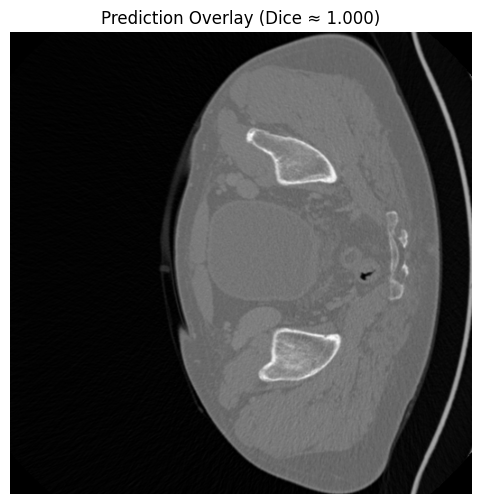

In [28]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# --- 1️⃣ Save model in the new Keras format ---
model.save("best_unet_lits17.keras")  # recommended format

print("✅ Model saved as 'best_unet_lits17.keras'")

# --- 2️⃣ Reload model with custom objects ---
model_reloaded = keras.models.load_model(
    "best_unet_lits17.keras",
    custom_objects={
        'bce_dice_loss': bce_dice_loss,
        'dice_coef': dice_coef
    }
)
print("✅ Model reloaded successfully")

# --- 3️⃣ Evaluate on validation set ---
val_loss, val_acc, val_dice = model_reloaded.evaluate(X_val, Y_val, verbose=1)
print(f"\n📊 Validation Results:\nLoss={val_loss:.4f}  Accuracy={val_acc:.4f}  Dice={val_dice:.4f}")

# --- 4️⃣ Predict one example and visualize ---
idx = 0
pred = model_reloaded.predict(X_val[idx:idx+1])[0,:,:,0]
plt.figure(figsize=(6,6))
plt.imshow(X_val[idx,:,:,0], cmap="gray")
plt.imshow(np.ma.masked_where(pred<0.5, pred), alpha=0.4, cmap="jet")
plt.title(f"Prediction Overlay (Dice ≈ {dice_numpy(Y_val[idx,:,:,0], pred>0.5):.3f})")
plt.axis("off")
plt.show()


In [29]:
import nibabel as nib
import numpy as np
from pathlib import Path

# --- 1️⃣ Select case to predict ---
case_id = 84  # change to any case that exists in your LiTS17 folder
vol, seg = load_case(case_id)

if vol is None:
    raise FileNotFoundError(f"⚠️ Case {case_id} not found. Check your folder paths.")

# --- 2️⃣ Predict slice-by-slice ---
pred_slices = []
for z in range(vol.shape[2]):
    sl = vol[:, :, z][None, :, :, None]           # shape (1, 512, 512, 1)
    pred = model_reloaded.predict(sl, verbose=0)[0, :, :, 0]
    pred_slices.append(pred)

pred_3d = np.stack(pred_slices, axis=2)
pred_mask = (pred_3d > 0.5).astype(np.uint8)

print(f"✅ Prediction complete for case {case_id}. Shape: {pred_mask.shape}")

# --- 3️⃣ Save as NIfTI (.nii.gz) ---
out_dir = Path(r"C:\Users\sohel\Downloads\Ai_health\LiTS17\predictions")
out_dir.mkdir(exist_ok=True)

# Use same affine/header as original volume for correct orientation
ref_img = nib.load(str(data_dir / f"volume-{case_id}.nii" / f"volume-{case_id}.nii"))
pred_img = nib.Nifti1Image(pred_mask, affine=ref_img.affine, header=ref_img.header)

out_path = out_dir / f"predicted_segmentation_case{case_id}.nii.gz"
nib.save(pred_img, str(out_path))

print(f"💾 Saved predicted mask to:\n{out_path}")


✅ Prediction complete for case 84. Shape: (512, 512, 733)
💾 Saved predicted mask to:
C:\Users\sohel\Downloads\Ai_health\LiTS17\predictions\predicted_segmentation_case84.nii.gz


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import numpy as np

def view_slices(z):
    plt.figure(figsize=(6,6))
    plt.imshow(vol[:, :, z], cmap="gray")
    plt.imshow(np.ma.masked_where(pred_mask[:,:,z]==0, pred_mask[:,:,z]), 
               alpha=0.4, cmap="jet")
    plt.title(f"Case {case_id} — Slice {z}")
    plt.axis("off")
    plt.show()

interact(view_slices, z=IntSlider(min=0, max=vol.shape[2]-1, step=1, value=vol.shape[2]//2))
